In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [8]:
# Paths to the CSV files
files = {
    "Advanced": "Advanced.csv",
    "Per36Minutes": "Per 36 Minutes.csv",
    "AwardShares": "Player Award Shares.csv",
    "PerGame": "Player Per Game.csv",
    "Shooting": "Player Shooting.csv",
    "Totals": "Player Totals.csv"
}

# Loading each file into a DataFrame
dfs = {name: pd.read_csv(path) for name, path in files.items()}

# Merging all DataFrames on common keys
common_keys = ['age', 'player', 'player_id', 'seas_id', 'season', 'tm']
merged_df = dfs['Advanced']
for name, df in dfs.items():
    if name != 'Advanced':
        merged_df = pd.merge(merged_df, df, on=common_keys, how='outer', suffixes=('', f'_{name}'))

merged_df.head()


,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,ft_percent_Totals,orb,drb,trb,ast,stl,blk,tov,pf,pts
0,31136,2024,5025,A.J. Green,NaN,SG,24.0,2,NBA,MIL,...,1.000,1.0,7.0,8.0,8,0.0,0.0,0.0,8,31
1,31137,2024,5027,AJ Griffin,NaN,SF,20.0,2,NBA,ATL,...,1.000,2.0,8.0,10.0,3,1.0,0.0,4.0,5,30
2,31138,2024,4219,Aaron Gordon,NaN,PF,28.0,10,NBA,DEN,...,0.520,42.0,73.0,115.0,61,18.0,14.0,29.0,31,210
3,31139,2024,4582,Aaron Holiday,NaN,PG,27.0,6,NBA,HOU,...,0.857,2.0,24.0,26.0,28,8.0,1.0,6.0,26,85
4,31140,2024,4805,Aaron Nesmith,NaN,SF,24.0,4,NBA,IND,...,0.654,15.0,34.0,49.0,15,17.0,8.0,9.0,49,156


In [9]:
# Creating the Y target variable (MVP award)
merged_df['Y'] = merged_df['award'] == 'nba mvp'

# Identifying potential numerical columns for X and removing redundant/irrelevant ones
numerical_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
irrelevant_or_duplicate_cols = ['birth_year_x', 'birth_year_y', 'experience_x', 'experience_y', 
                                'g_x', 'g_y', 'mp_x', 'mp_y', 'fg_percent_x', 'fg_percent_y', 
                                'e_fg_percent_x', 'e_fg_percent_y', 'ft_percent_x', 'ft_percent_y']
final_numerical_columns = [col for col in numerical_columns if col not in irrelevant_or_duplicate_cols]

# Creating the X features DataFrame and handling missing values
X = merged_df[final_numerical_columns]
missing_value_threshold = 0.5 * len(merged_df)
columns_to_exclude = X.columns[X.isnull().sum() > missing_value_threshold]
X = X.drop(columns=columns_to_exclude).fillna(X.mean())

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, merged_df['Y'], test_size=0.2, random_state=42)


In [10]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],    
    'bootstrap': [True, False]        
}

In [11]:
# Hyperparameter Tuning using Grid Search with Cross-Validation
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  22.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  22.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  23.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; tota

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [12]:
# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

In [13]:
# Evaluate the Best Model from Grid Search
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [14]:
# Print the results
print("Best Parameters:", best_params)
print("Model Accuracy:", accuracy)
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Model Accuracy: 0.9707756878594745
Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.99      0.98      6210
        True       0.64      0.36      0.46       223

    accuracy                           0.97      6433
   macro avg       0.81      0.68      0.72      6433
weighted avg       0.97      0.97      0.97      6433

Confusion Matrix:
 [[6165   45]
 [ 143   80]]


In [15]:
# Get Feature Importances from the Best Model
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top 30 Feature Importances:\n", feature_importances.head(30))

Top 30 Feature Importances:
 pts                0.058506
vorp               0.049019
ws                 0.046011
fta                0.035123
fg                 0.034400
ws_48              0.031642
fg_per_game        0.031186
pts_per_game       0.029072
per                0.028498
ows                0.026082
x2pa               0.024598
dws                0.022361
x2p_per_game       0.021554
fga                0.021054
x2pa_per_game      0.020125
bpm                0.019906
ft                 0.019282
fta_per_game       0.018819
fga_per_game       0.016390
x2p                0.015621
obpm               0.015377
mp_Per36Minutes    0.015368
mp_per_game        0.014083
ast                0.011402
mp_Totals          0.011238
pts_per_36_min     0.010149
mp                 0.009354
tov                0.009296
trb                0.008914
trb_per_game       0.008834
dtype: float64


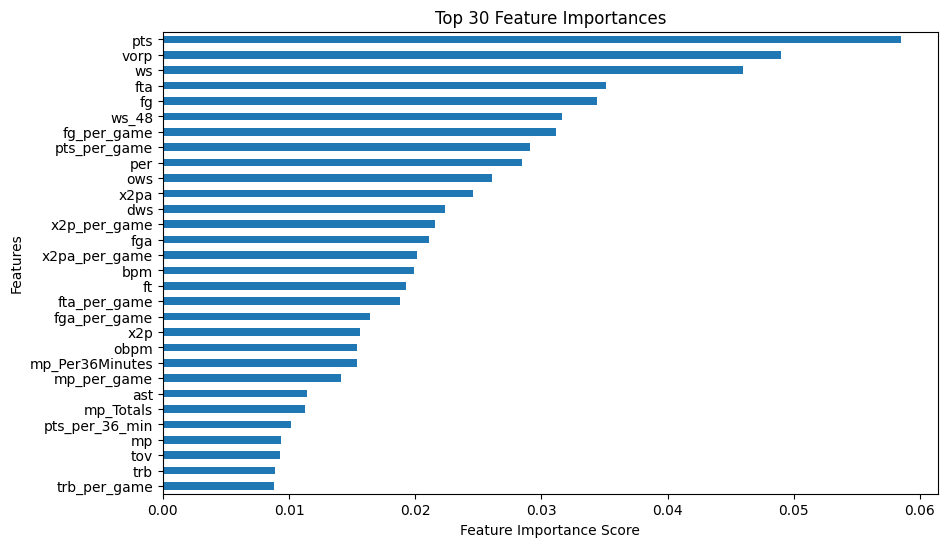

In [16]:
# Feature Importance Visualization
import matplotlib.pyplot as plt
top_n = 30
plt.figure(figsize=(10, 6))
feature_importances.iloc[:top_n].plot(kind='barh')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis() 
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()